# Part 1: Optimal Transport and Wasserstein Distances

The goal of this first practical session is to introduce computational optimal transport (OT) in Python. You will familiarize yourself with OT by:
1. using the Python library POT (Python Optimal Transport),
2. coding Sinkhorn's algorithm.



You first need to install the package POT:
* Install with pip: ```bash pip install pot```

In [ ]:
# Check your installation by importing POT
!pip install pot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 8.1 MB/s 


In [ ]:
import ot
from ot.datasets import make_1D_gauss as gauss
import ot.plot
import numpy as np
import matplotlib.pyplot as plt

## 1. Solving Exact OT: Linear Programming

### Reminders on Optimal Transport

Optimal Transport is a theory that allows us to compare two (weighted) points clouds $(X, a)$ and $(Y, b)$, where $X \in \mathbb{R}^{n \times d}$ and $Y \in \mathbb{R}^{m \times d}$ are the locations of the $n$ (resp. $m$) points in dimension $d$, and $a \in \mathbb{R}^n$, $b \in \mathbb{R}^m$ are the weights. We ask that the total weights sum to one, i.e. $\sum_{i=1}^n a_i = \sum_{j=1}^m b_j = 1$.

The basic idea of Optimal Transport is to "transport" the mass located at points $X$ to the mass located at points $Y$.

Let us denote by $\mathcal{U}(a,b) = \left\{ P \in \mathbb{R}^{n \times m} \,|\, P \geq 0, \sum_{j=1}^m P_{ij} = a_i, \sum_{i=1}^n P_{ij} = b_j\right\}$ the set of admissible transport plans.

If $P \in \mathcal{U}(a,b)$, the quantity $P_{ij} \geq 0$ should be regarded as the mass transported from point $X_i$ to point $Y_j$. For this reason, it is called a *transport plan*.

We will also consider a *cost matrix* $C \in \mathbb{R}^{n \times m}$. The quantity $C_{ij}$ should be regarded as the cost paid for transporting one unit of mass from $X_i$ to $Y_j$. This cost is usually computed using the positions $X_i$ and $Y_j$, for example $C_{ij} = \|X_i - Y_j\|$ or $C_{ij} = \|X_i - Y_j\|^2$.

Then transporting mass according to $P \in \mathcal{U}(a,b)$ has a total cost of $\sum_{ij} P_{ij} C_{ij}$.

In "Optimal Transport", there is the word _Optimal_. Indeed, we want to find a transport plan $P \in \mathcal{U}(a,b)$ that will minimize its total cost. In other words, we want to solve
$$
    \min_{P \in \mathcal{U}(a,b)} \sum_{ij} C_{ij }P_{ij}.
$$

This problem is a Linear Program: the objective function is linear in the variable $P$, and the constraints are linear in $P$. We can thus solve this problem using classical Linear Programming algorithms, such as the simplex algorithm.

If $P^*$ is a solution to the Optimal Transport problem, we will say that $P^*$ is an optimal transport plan between $(X, a)$ and $(Y, b)$, and that $\sum_{ij} P^*_{ij} C_{ij}$ is the optimal transport distance between $(X, a)$ and $(Y, b)$: it is the minimal amount of "energy" that is necessary to transport the initial mass located at points $X$ to the target mass lcoated at points $Y$.

### Data

---



One dimensional data (two histograms)

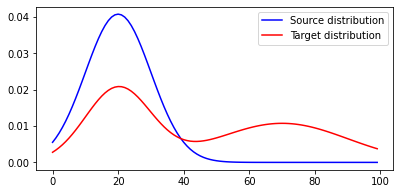

In [ ]:
n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)
y = np.arange(n, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=20, s=10)  # m= mean, s= std
b = gauss(n, m=70, s=20)
b = 0.5*a + 0.5*b

C = np.zeros((n,n))

### Distance square cost function
for i in range(n):
    for j in range(n):
        C[i,j] = (x[i] - y[j])**2

plt.figure(1, figsize=(6.4, 3))
plt.plot(x, a, 'b', label='Source distribution')
plt.plot(x, b, 'r', label='Target distribution')
plt.legend()

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in Palaiseau.

We use fictional positions, production and sale numbers (that both sum to the same value).

We have acess to the position of Bakeries $X \in \mathbb{R}^{8 \times 2}$ and their respective production $a \in \mathbb{R}^8$ which describe the source point cloud. The Cafés where the croissants are sold are defined by their position $Y \in \mathbb{R}^{5 \times 2}$ and $b \in \mathbb{R}^{5}$.

872.4977923209124


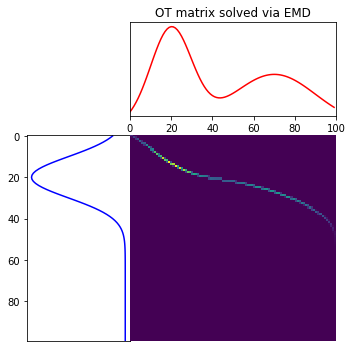

In [ ]:
## Computing the (exact) optimal transport plan and the optimal transport distance for the L1 and L2 costs via Linear Programming
P0 = ot.emd(a,b,C)

plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, P0, 'OT matrix solved via EMD')

## Computing the Optimal Transport cost
OT_cost_C = np.sum(P0*C)
print(OT_cost_C)

## 2. Sinkhorn Algorithm for Entropy Regularized Optimal Transport

### Reminders on Sinkhorn Algorithm

In real applications, and especially in Machine Learning, we often have to deal with huge numbers of points. In this case, the linear programming algorithms which have cubic complexity will take too much time to run.

That's why in practise, among other reasons, people minimize another criterion given by
$$
    \min_{P \in \mathcal{U}(a,b)} \langle C, P \rangle + \epsilon \sum_{ij} P_{ij} [ \log(P_{ij}) - 1].
$$
When $\epsilon$ is sufficiently small, we can consider that a solution to the above problem (often refered to as "Entropy-regularized Optimal Transport") is a good approximation of a real optimal transport plan.

In order to solve this problem, one can remark that the optimality conditions imply that a solution $P_\epsilon^*$ necessarily is of the form $P_\epsilon^* = \text{diag}(u) \, K \, \text{diag}(v)$, where $K = \exp(-C/\epsilon)$ and $u,v$ are two non-negative vectors.

$P_\epsilon^*$ should verify the constraints, i.e. $P_\epsilon^* \in \mathcal{U}(a,b)$, so that
$$
    P_\epsilon^* 1_m = a \text{  and  } (P_\epsilon^*)^T 1_n = b
$$
which can be rewritten as
$$
    u \odot (Kv) = a \text{  and  } v \odot (K^T u) = b
$$

Then Sinkhorn's algorithm alternate between the resolution of these two equations, and reads
$$
    u \leftarrow \frac{a}{Kv} \text{  and  } v \leftarrow \frac{b}{K^T u}
$$

In [ ]:
def sinkhorn(a, b, C, epsilon=0.1, max_iters=100):
    """Run Sinnkhorn's algorithm"""
    
    # Compute the kernel matrix K

    
    # Alternate projections
    
    return np.diag(u).dot(K).dot(np.diag(v))

We are going to solve our previous one-dimensional example using the Sinkhorn algorithm.

In [ ]:
P10 = sinkhorn(a, b, C, epsilon=10)

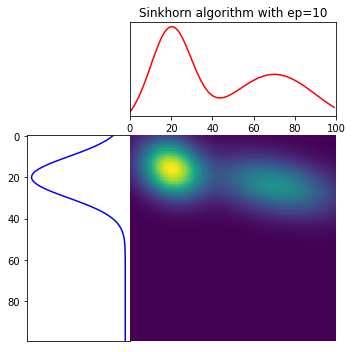

In [ ]:
plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, P10, 'Sinkhorn algorithm with ep=10')

In [ ]:
### Diference between Sinkhorn and EMD
coupling_diff = []
dist_diff = []
for epsilon in np.linspace(10, 100, 1000, 10000):
       OT_plan_sinkhorn = sinkhorn(a, b, C/C.max(), epsilon, 1000)
       OT_cost_sinkhorn = 
        ### Do yourself


[0.09712403934609154, 0.09712414514923841, 0.09712424908037308, 0.09712435118874267, 0.09712445152188187, 0.0971245501256868, 0.09712464704448505, 0.09712474232110202, 0.09712483599692412, 0.09712492811195864, 0.09712501870489075, 0.0971251078131376, 0.09712519547290001, 0.0971252817192113, 0.09712536658598411, 0.09712545010605482, 0.0971255323112259, 0.0971256132323063, 0.09712569289914993, 0.09712577134069242, 0.09712584858498605, 0.09712592465923336, 0.09712599958981896, 0.09712607340234011, 0.09712614612163585, 0.0971262177718148, 0.09712628837628198, 0.09712635795776411, 0.0971264265383341, 0.0971264941394344, 0.09712656078189934, 0.09712662648597643, 0.09712669127134711, 0.09712675515714612, 0.09712681816198059, 0.09712688030394792, 0.09712694160065326, 0.09712700206922598, 0.09712706172633581, 0.09712712058820801, 0.09712717867063812, 0.09712723598900623, 0.09712729255829024, 0.0971273483930793, 0.09712740350758604, 0.09712745791565879, 0.09712751163079313, 0.09712756466614308, 

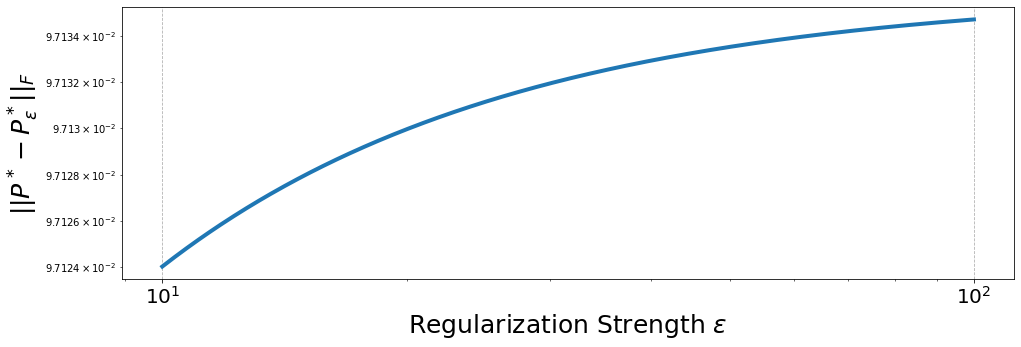

In [ ]:
plt.figure(figsize=(16,5))
plt.loglog(np.linspace(10, 100, 1000, 10000), coupling_diff, lw=4)
plt.xlabel('Regularization Strength $\epsilon$', fontsize=25)
plt.ylabel('$||P^* - P_\epsilon^*||_F$', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(ls='--')
plt.show()

Let is now do a two dimensional problem of transporting "croissants" to "Bakeries" or "Maple Syrop" to "Pancakes".

In [ ]:
n = 10
m = 10
d = 2

X = np.random.randn(n,d)
Y = np.random.randn(m,d)

a = np.ones(n)
b = np.ones(m)



C_1 = (((X[:, None] - Y)**2)**0.5).sum(axis=2)
#optimal_plan_sinkhorn_1 = sinkhorn(a, b, C_1/C_1.max(), epsilon=0.01)

C_2 = ((X[:, None] - Y)**2).sum(axis=2)

#optimal_plan_sinkhorn_2 = sinkhorn(a, b, C_2/C_2.max(), epsilon=0.01)


In [ ]:
## Safe check solving OT via Linear programming

optimal_plan_1 = ot.emd(a, b, C_1)
print(optimal_plan_1)
optimal_cost_1 = np.sum(optimal_plan_1*C_1)
print('1-Wasserstein distance =', optimal_cost_1)
print('')

optimal_plan_2 = ot.emd(a, b, C_2)
print(optimal_plan_2)
optimal_cost_2 = np.sum(optimal_plan_2*C_2)
print('2-Wasserstein distance =', np.sqrt(optimal_cost_2))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
1-Wasserstein distance = 9.932112085626667

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
2-Wasserstein distance = 2.779005296066458


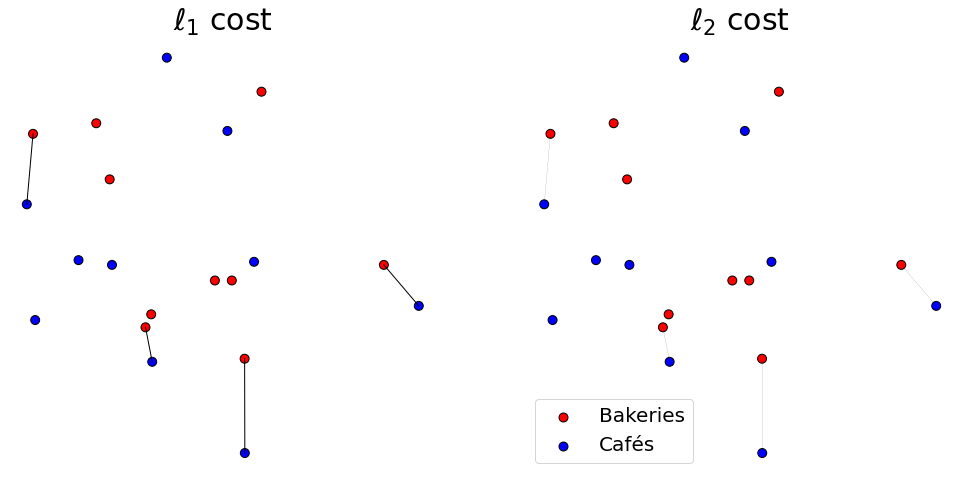

In [ ]:
fig = plt.figure(figsize=(17,8))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], s=80*a, c='r', edgecolors='k', label='Bakeries')
ax.scatter(Y[:,0], Y[:,1], s=80*b, c='b', edgecolors='k', label='Cafés')
for i in range(8):
    for j in range(5):
        ax.plot([X[i,0], Y[j,0]], [X[i,1], Y[j,1]], c='k', lw=1*optimal_plan_1[i,j], alpha=1)
ax.axis('off')
ax.set_title('$\ell_1$ cost', fontsize=30)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(X[:,0], X[:,1], s=80*a, c='r', edgecolors='k', label='Bakeries')
ax.scatter(Y[:,0], Y[:,1], s=80*b, c='b', edgecolors='k', label='Cafés')
for i in range(8):
    for j in range(5):
        ax.plot([X[i,0], Y[j,0]], [X[i,1], Y[j,1]], c='k', lw=0.1*optimal_plan_2[i,j], alpha=1)
ax.axis('off')
ax.set_title('$\ell_2$ cost', fontsize=30)

plt.legend(fontsize=20)
plt.show()

In [ ]:
optimal_plan_2

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# Solve with Sinkhorn 
optimal_plan_sinkhorn_1 = sinkhorn(a, b, C_1/C_1.max(), epsilon=0.1)
optimal_plan_sinkhorn_2 = sinkhorn(a, b, C_2/C_2.max(), epsilon=0.1)

We first show that this algorithm is consistent with classical optimal transport, using the "croissant"/"maple syrop" transport example.

In [ ]:
plan_diff = []
distance_diff = []
for epsilon in np.linspace(0.01, 1, 100):
    ### Do yourself

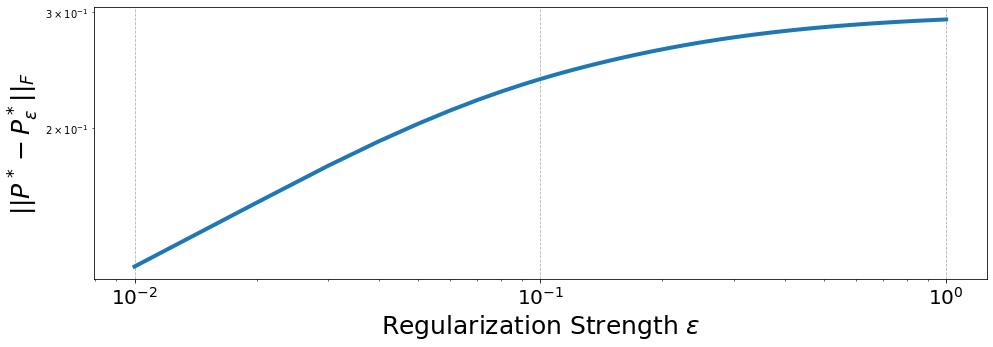

In [ ]:
plt.figure(figsize=(16,5))
plt.loglog(np.linspace(0.01, 1, 100), plan_diff, lw=4)
plt.xlabel('Regularization Strength $\epsilon$', fontsize=25)
plt.ylabel('$||P^* - P_\epsilon^*||_F$', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(ls='--')
plt.show()

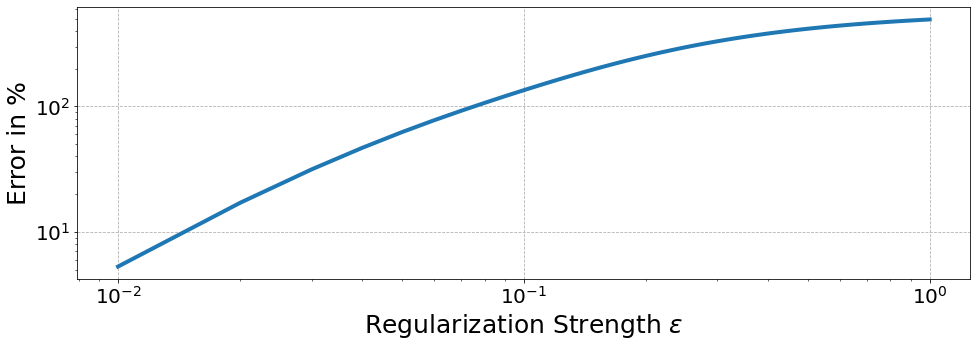

In [ ]:
plt.figure(figsize=(16,5))
plt.loglog(np.linspace(0.01, 1, 100), distance_diff, lw=4)
plt.xlabel('Regularization Strength $\epsilon$', fontsize=25)
plt.ylabel('Error in %', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(ls='--')
plt.show()